In [95]:
import gymnasium as gym
import highway_env
import matplotlib.pyplot as plt
import utils 
import numpy as np
from scipy.stats import norm
import agents
import torch

%load_ext autoreload
%autoreload 2
%cd project

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: 'project'
/project


In [87]:
# env = gym.make('highway-v0')
env = gym.make('highway-fast-v0')
obs, info = env.reset()
env.config

/opt/conda/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 5,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 3,
 'vehicles_count': 20,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 30,
 'ego_spacing': 1.5,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'normalize_reward': True,
 'offroad_terminal': False}

In [96]:
# check the action space
env.action_type.actions_indexes

{'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}

In [94]:
# check the observation space
obs = env.observation_type.observe()
obs

array([[ 1.        ,  1.        ,  0.6666667 ,  0.3042717 ,  0.        ],
       [ 1.        ,  0.05826465,  0.        , -0.04888715,  0.        ],
       [ 1.        ,  0.14961703, -0.33333334, -0.04008864,  0.        ],
       [ 1.        ,  0.28675976, -0.6666667 , -0.05285531,  0.        ],
       [ 1.        ,  0.35726598,  0.        , -0.05807787,  0.        ]],
      dtype=float32)

In [43]:
# Parameters
NUM_EPISODES = 100

In [34]:
# Run the environment
total_cumulative_rewards = []
collision_rate = 0
duration_env = env.config['duration']

obs, info = env.reset()
custPrint = utils.CustomPrint(env)
for episode in range(NUM_EPISODES):
    obs, info = env.reset()
    episode_cumulative_reward = []
    done = False
    truncated = False
    while not done and not truncated:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        episode_cumulative_reward.append(reward)
        # custPrint.print_action(action)
        custPrint.print_obs(obs)
        env.render()

    total_cumulative_rewards.append(episode_cumulative_reward)
    
    if info['crashed']:
        collision_rate += 1
    
env.close()

avg_rewards = np.array([np.mean(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
std_rewards = np.array([np.std(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
collision_rate = collision_rate / NUM_EPISODES

print(f"Average reward per episode: {avg_rewards}")
print(f"Collision percentage rate: {collision_rate*100}%")




ego-vehicle: presence: 1.0, x: 0.8800, y: 0.3000, vx: 0.3100, vy: 0.0100
vehicle 1: presence: 1.0, x: 0.1200, y: 0.0900, vx: -0.0500, vy: 0.0700
vehicle 2: presence: 1.0, x: 0.2400, y: -0.3000, vx: -0.0400, vy: -0.0100
vehicle 3: presence: 1.0, x: 0.3700, y: 0.0300, vx: -0.0300, vy: -0.0100
vehicle 4: presence: 1.0, x: 0.4700, y: 0.3600, vx: -0.0500, vy: -0.0100

ego-vehicle: presence: 1.0, x: 0.9900, y: 0.3300, vx: 0.2600, vy: 0.0000
vehicle 1: presence: 1.0, x: 0.1100, y: 0.3200, vx: 0.0100, vy: 0.0100
vehicle 2: presence: 1.0, x: 0.2300, y: -0.3300, vx: 0.0100, vy: -0.0000
vehicle 3: presence: 1.0, x: 0.3700, y: 0.0000, vx: 0.0200, vy: -0.0000
vehicle 4: presence: 1.0, x: 0.4600, y: 0.3300, vx: -0.0000, vy: -0.0000

ego-vehicle: presence: 1.0, x: 1.0000, y: 0.3300, vx: 0.2500, vy: 0.0000
vehicle 1: presence: 1.0, x: 0.1200, y: 0.3300, vx: 0.0100, vy: 0.0000
vehicle 2: presence: 1.0, x: 0.2400, y: -0.3300, vx: 0.0100, vy: -0.0000
vehicle 3: presence: 1.0, x: 0.3800, y: 0.0000, vx: 0

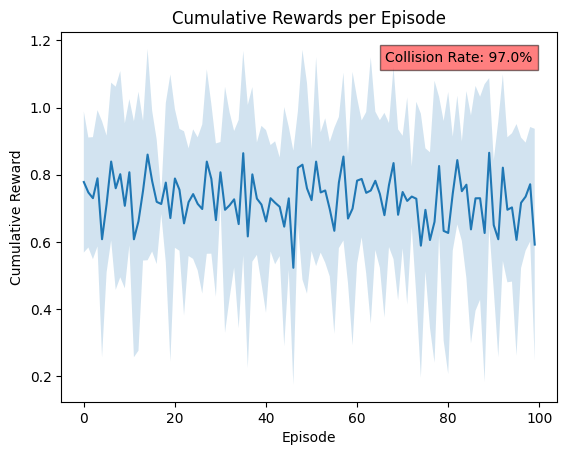

In [64]:
# Plot the mean cumulative rewards
plt.plot(avg_rewards)

# Add the variance using fill_between
plt.fill_between(range(len(avg_rewards)), avg_rewards - std_rewards, avg_rewards + std_rewards, alpha=0.2)
# Add collision rate box to the plot
plt.text(0.95, 0.95, f"Collision Rate: {collision_rate*100}%", horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.5))

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
# Show the plot
plt.show()

# Training with DQN agent

In [51]:
dqn_agent = agents.DQNAgent(env.observation_space.shape[0] * env.observation_space.shape[1], 
                            env.action_space.n,
                            lr=5e-4,
                            gamma=0.8,
                            epsilon=0.8,
                            epsilon_decay=0.9995,
                            epsilon_min=0.01,
                            tau=1e-3,
                            update_target_freq=4)
                            

In [52]:
dqn_agent.train(env, num_episodes=1000, batch_size=128, render=True)

Episode: 1/1000, Total Reward: 3.9121841316266566, Epsilon: 0.8, Loss: inf
Episode: 2/1000, Total Reward: 14.179313886922834, Epsilon: 0.79, Loss: inf
Episode: 3/1000, Total Reward: 6.612640234166579, Epsilon: 0.79, Loss: inf
Episode: 4/1000, Total Reward: 14.578204485924928, Epsilon: 0.78, Loss: inf
Episode: 5/1000, Total Reward: 7.751598121265722, Epsilon: 0.78, Loss: inf
Episode: 6/1000, Total Reward: 16.977665656045353, Epsilon: 0.77, Loss: inf
Episode: 7/1000, Total Reward: 2.118315462896295, Epsilon: 0.77, Loss: inf
Episode: 8/1000, Total Reward: 4.1987960379955265, Epsilon: 0.77, Loss: inf
Episode: 9/1000, Total Reward: 16.845516728344354, Epsilon: 0.76, Loss: inf
Episode: 10/1000, Total Reward: 1.9130006968016178, Epsilon: 0.76, Loss: inf
Episode: 11/1000, Total Reward: 3.417558299039781, Epsilon: 0.76, Loss: inf
Episode: 12/1000, Total Reward: 2.8973833082431524, Epsilon: 0.75, Loss: inf
Episode: 13/1000, Total Reward: 12.178848837087392, Epsilon: 0.75, Loss: 0.35
Episode: 14/

## Inference with DQN agent

In [72]:
# load the model weights in a different agent object
dqn_agent_loaded = agents.DQNAgent(env.observation_space.shape[0] * env.observation_space.shape[1],
                            env.action_space.n)
dqn_agent_loaded.dqn.load_state_dict(torch.load('dqn_model_best.pt'))

<All keys matched successfully>

In [53]:
# Run the environment on the trained agent
total_cumulative_rewards = []
collision_rate = 0
duration_env = env.config['duration']

obs, info = env.reset()
for episode in range(NUM_EPISODES):
    obs, info = env.reset()
    episode_cumulative_reward = []
    done = False
    truncated = False
    while not done and not truncated:
        action = dqn_agent_loaded.act(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_cumulative_reward.append(reward)

        env.render()

    total_cumulative_rewards.append(episode_cumulative_reward)
    
    if info['crashed']:
        collision_rate += 1
    
env.close()

avg_rewards = np.array([np.mean(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
std_rewards = np.array([np.std(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
collision_rate = collision_rate / NUM_EPISODES

print(f"Average reward per episode: {avg_rewards}")
print(f"Collision percentage rate: {collision_rate*100}%")


Average reward per episode: [0.76895018 0.88832488 0.81886486 0.8228489  0.75509768 0.87280017
 0.79951996 0.79391497 0.79447727 0.77786654 0.83058878 0.81480425
 0.76510955 0.76390203 0.73195898 0.79065949 0.80195466 0.81432493
 0.82651643 0.77956293 0.78612934 0.7702636  0.74065863 0.84097525
 0.83726161 0.78339053 0.77280511 0.83837405 0.69012369 0.80834634
 0.72620404 0.87806494 0.83129294 0.76857828 0.71843107 0.86420311
 0.80956293 0.77060535 0.79280948 0.75395281 0.80511848 0.86946542
 0.80067404 0.79664951 0.80280831 0.79323185 0.88700231 0.77398663
 0.73173989 0.76359474 0.79949917 0.79536367 0.83846335 0.7917501
 0.78931858 0.76396438 0.80286011 0.78505791 0.84948812 0.80889132
 0.81059535 0.82165359 0.84168942 0.83115118 0.91112297 0.78842067
 0.77647873 0.85801301 0.72067404 0.81485857 0.77400737 0.84907664
 0.79176348 0.77994963 0.68956293 0.76201813 0.81946042 0.77092632
 0.81948425 0.80937725 0.74330928 0.7784063  0.87459203 0.79981083
 0.89736038 0.80006784 0.83500662 0

### Wrong model

This model learned to slow down behind one vehicle and remain like that to get almost 0% collision rate, but it didn't get much rewards from the environment as it was going too slow and not changing lanes. That's why its performance is worse than the random agent.

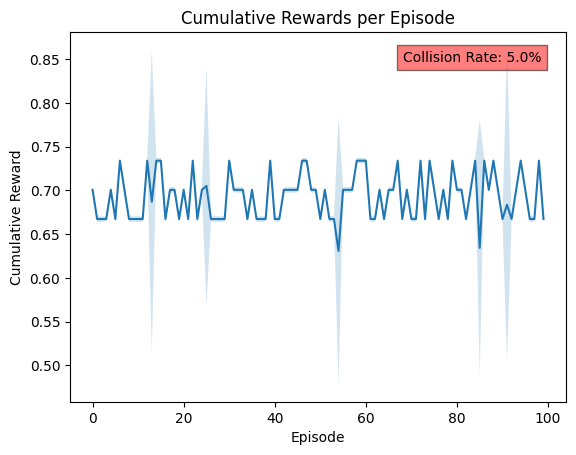

In [83]:
# Plot the mean cumulative rewards
plt.plot(avg_rewards)

# Add the variance using fill_between
plt.fill_between(range(len(avg_rewards)), avg_rewards - std_rewards, avg_rewards + std_rewards, alpha=0.2)
# Add collision rate box to the plot
plt.text(0.95, 0.95, f"Collision Rate: {collision_rate*100}%", horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.5))

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
# Show the plot
plt.show()

### Results final desired DQN agent

This model learned to change lanes and go faster, but it didn't get 0% collision rate. However, it got much more rewards from the environment, better
than the random agent.

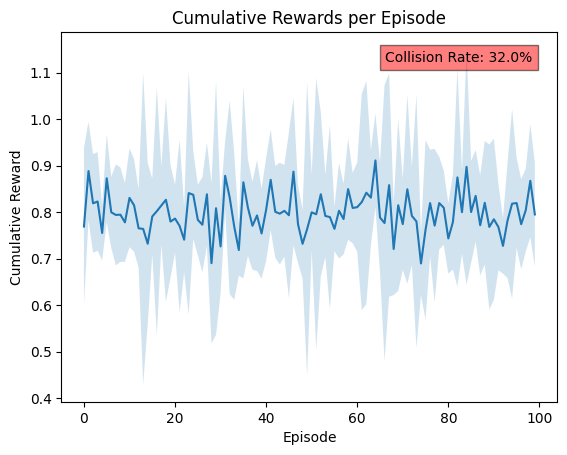

In [54]:
# Plot the mean cumulative rewards
plt.plot(avg_rewards)

# Add the variance using fill_between
plt.fill_between(range(len(avg_rewards)), avg_rewards - std_rewards, avg_rewards + std_rewards, alpha=0.2)
# Add collision rate box to the plot
plt.text(0.95, 0.95, f"Collision Rate: {collision_rate*100}%", horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.5))

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
# Show the plot
plt.show()

# Video demo

In [97]:
dqn_agent_loaded = agents.DQNAgent(env.observation_space.shape[0] * env.observation_space.shape[1],
                            env.action_space.n)
dqn_agent_loaded.dqn.load_state_dict(torch.load('dqn_model_best.pt'))

<All keys matched successfully>

In [100]:
NUM_EPISODES = 10
# Run the environment on the trained agent
total_cumulative_rewards = []
collision_rate = 0
duration_env = env.config['duration']

obs, info = env.reset()
for episode in range(NUM_EPISODES):
    obs, info = env.reset()
    episode_cumulative_reward = []
    done = False
    truncated = False
    while not done and not truncated:
        # action = env.action_space.sample() # random agent
        action = dqn_agent_loaded.act(obs) # dqn agent
        obs, reward, done, truncated, info = env.step(action)
        episode_cumulative_reward.append(reward)

        env.render()

    total_cumulative_rewards.append(episode_cumulative_reward)
    
    if info['crashed']:
        collision_rate += 1
    
env.close()

avg_rewards = np.array([np.mean(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
std_rewards = np.array([np.std(cumulative_rewards) for cumulative_rewards in total_cumulative_rewards])
collision_rate = collision_rate / NUM_EPISODES

print(f"Average reward per episode: {avg_rewards}")
print(f"Collision percentage rate: {collision_rate*100}%")


Average reward per episode: [0.74617974 0.79672919 0.79219958 0.80147197 0.85829432 0.76064417
 0.7882927  0.76829444 0.76089064 0.88095565]
Collision percentage rate: 30.0%


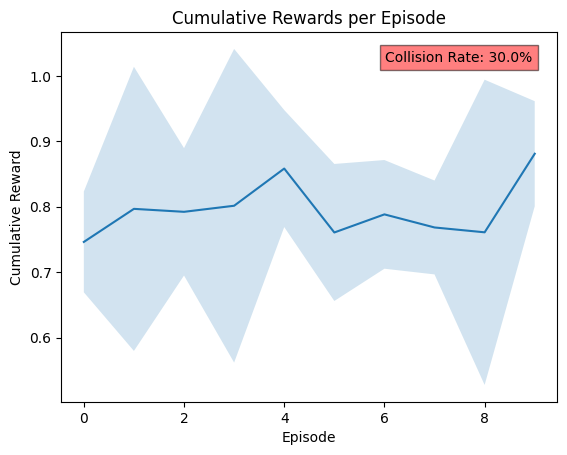

In [101]:
# Plot the mean cumulative rewards
plt.plot(avg_rewards)

# Add the variance using fill_between
plt.fill_between(range(len(avg_rewards)), avg_rewards - std_rewards, avg_rewards + std_rewards, alpha=0.2)
# Add collision rate box to the plot
plt.text(0.95, 0.95, f"Collision Rate: {collision_rate*100}%", horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.5))

# Add labels and title
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')
# Show the plot
plt.show()